## Ejercicio completo de machine learning 1: 

Clasificación de puntos en un plano según dos posibles categorias, puntos rojos o azules

Este notebook incluye todos los pasos tipicos de un ejercicio de Machine Learning, enfocandose en un problema de clasificacion entre dos categorias (rojo o azul) de los puntos de un plano. Todo esto en busqueda del grafico 2.4 del libro The Elements. Este notebook se dividirá en las siguientes partes:

- Simulación de datos del train y del test
    - En muchos ejercicios de Machine Learning estos datos son dados como condicion inicial, pero en nuestro caso nosotros los simulamos. Debemos recordar que una de las suposiciones de ML es que los datos siguen cierta funcion de probabilidad y que en principio conociendo esta funcion podriamos simularlos
- Definicion de la función para calcular las predicciones o hacer la clasificacion (lineal, Knn, etc)
    - En el lenguaje de ML esta funcion es llamada Hipótesis
- Definicion de la función costo 
    -  En un primer caso usamos RSS como funcion de costo, pero en general podriamos considerar otras funciones de costo, dependiendo de las propiedades particulares de cada problema
- Minimización de la función costo para encontrar los parámetros libres de la hipótesis 
    - En un primer caso encontramos los valores de los parametros theta de la funcion lineal minimizando  teoricamente la funcion costo RSS. Sin embargo es necesario notar que también existen otros metodos, que son numericos en general. Por ejemplo, anteriormente usamos la busqueda aleatoria de los paramteros seleccionando sistematicamente los valores que reducen RSS. Otro metodo, con nombre de hecho, es Gradient Descent que es el mas tipico de Machine Learning (tarea)
- Visualizacion de las predicciones en el train y el test
- Evaluacion cuantitativa de las predicciones en terminos de la accuracy y el test error
    - Estos resultados nos permitiran escoger los mejores modelos para el problema planteado
- Gráfico de la misclassification curves (Figure 2.4)

Inicialmente importamos la librería que utilizaremos:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Simulación de datos:

AC: Para esta simulación reutilizaré los códigos de los notebooks anteriores. Aquí se usarán dos SETs de datos (SET_train y SET_test), los cuales tendrán un tamaño de 200 y 10000 ejemplos respectivamente.

### Definicion de los centros de las gaussianas bivariadas

In [2]:
def centros_asociados_a_cada_color(color, kcentros):
   
    centro = np.array([0,0])
    covarianza = np.identity(2)
    
    if color == 0: #azul
        centro = np.array([1,0])
    
    if color == 1: #rojo
        centro = np.array([0,1])

    lista_de_centros = np.random.multivariate_normal(centro,covarianza,kcentros).T
        
    return lista_de_centros

In [3]:
centros_azul = centros_asociados_a_cada_color(0,10)
centros_rojo = centros_asociados_a_cada_color(1,10)

In [4]:
def visualize_colors(ptos_azul, ptos_rojo):

    x1azul = ptos_azul[0]
    x2azul = ptos_azul[1]
    
    x1rojo = ptos_rojo[0]
    x2rojo = ptos_rojo[1]
    
    plt.plot(x1azul,x2azul,"bo")
    plt.plot(x1rojo,x2rojo,"ro")
    plt.axis([-4,4,-4,4])
    plt.title("Distribucion de puntos segun el color")
    plt.show() 

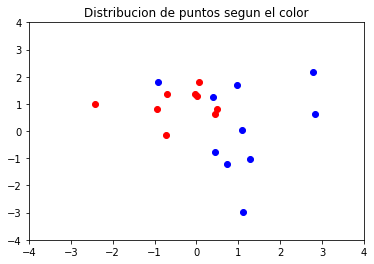

In [5]:
visualize_colors(centros_azul, centros_rojo)

### Implementacion de la funcion que simula los datos

In [6]:
def Simulacion_2(centros, N):
    
    Ncentros = centros.shape[1]
    
    #Initialize the list of observations 
    observations = np.zeros((2,N))
    
    #we first define the global value of the covariance
    covarianza = np.identity(2)/5
       
    #hacemos un loop entre 0 y N-1 para generar todos las observaciones requeridas
    
    for obs in range(0,N):
        #generamos un numero aleatorio entre 0 y 9 para escoger el centro de nuestra gaussiana bivariada
        indice_del_centro = random.randint(0, Ncentros-1)
        
        xcentro = centros[0,indice_del_centro]
        ycentro = centros[1,indice_del_centro]
        
        mk_centro = np.array([xcentro, ycentro])
        
        centro_aux = np.random.multivariate_normal(mk_centro,covarianza,1).T
    
        observations[0,obs] = centro_aux[0,0]
        observations[1,obs] = centro_aux[1,0]
    
    return observations

### Datos del train

In [7]:
ptos_observados_azul_train =  Simulacion_2(centros_azul, 100)
ptos_observados_rojo_train =  Simulacion_2(centros_rojo, 100)

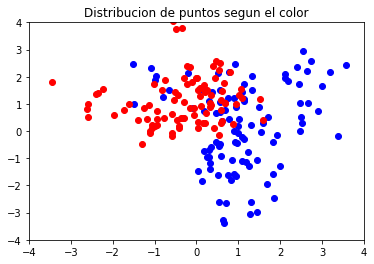

In [8]:
visualize_colors(ptos_observados_azul_train, ptos_observados_rojo_train)

### Datos del test
AC: Ahora generaré 5000 puntos para cada color (en total serán 10000 puntos) a partir de los mismos 20 centros usados para la training sample. 

In [9]:
ptos_observados_azul_test =  Simulacion_2(centros_azul, 5000)
ptos_observados_rojo_test =  Simulacion_2(centros_rojo, 5000)

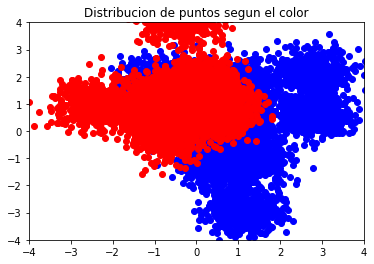

In [10]:
visualize_colors(ptos_observados_azul_test, ptos_observados_rojo_test)

Por el momento generaré un muestra de testeo más reducida que la anterior, ya que mi computadora no puede procesar el knn para los 10000 puntos, se demora demasiado

In [11]:
ptos_observados_azul_test_2 =  Simulacion_2(centros_azul, 500) #serán 1000 puntos en total
ptos_observados_rojo_test_2 =  Simulacion_2(centros_rojo, 500)

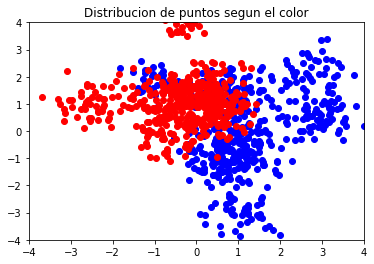

In [12]:
visualize_colors(ptos_observados_azul_test_2, ptos_observados_rojo_test_2)

AC: ahora con estos puntos puedo generar los dos SETs que utilizaré

In [13]:
SET_train=[]

#PRIMERO FORMAMOS EL SET_training
x1azul_train = ptos_observados_azul_train[0,:]
x2azul_train = ptos_observados_azul_train[1,:]

x1rojo_train = ptos_observados_rojo_train[0,:]
x2rojo_train = ptos_observados_rojo_train[1,:]

#Agregamos los correspondientes a y=0 (distribución normal azul)
for i in range(len(x1azul_train)):
    SET_train.append([1,x1azul_train[i],x2azul_train[i],0])

#Ahora agregamos los correspondientes a y=1 (distribución normal roja)
for i in range(len(x1rojo_train)):
    SET_train.append([1,x1rojo_train[i],x2rojo_train[i],1])

In [14]:
#AHORA FORMAMOS EL SET_test
SET_test=[]

x1azul_test = ptos_observados_azul_test[0,:]
x2azul_test = ptos_observados_azul_test[1,:]

x1rojo_test = ptos_observados_rojo_test[0,:]
x2rojo_test = ptos_observados_rojo_test[1,:]

for i in range(len(x1azul_test)):
    SET_test.append([1,x1azul_test[i],x2azul_test[i],0])

#Ahora agregamos los correspondientes a y=1 (distribución normal roja)
for i in range(len(x1rojo_test)):
    SET_test.append([1,x1rojo_test[i],x2rojo_test[i],1])

In [15]:
#FORMAMOS EL SET_test_2
SET_test_2=[]

x1azul_test_2 = ptos_observados_azul_test_2[0,:]
x2azul_test_2 = ptos_observados_azul_test_2[1,:]

x1rojo_test_2 = ptos_observados_rojo_test_2[0,:]
x2rojo_test_2 = ptos_observados_rojo_test_2[1,:]

for i in range(len(x1azul_test_2)):
    SET_test_2.append([1,x1azul_test_2[i],x2azul_test_2[i],0])

#Ahora agregamos los correspondientes a y=1 (distribución normal roja)
for i in range(len(x1rojo_test_2)):
    SET_test_2.append([1,x1rojo_test_2[i],x2rojo_test_2[i],1])

Veamos si están bien hechos estos SETs:

In [16]:
print(len(SET_train), len(SET_test),len(SET_test_2))

200 10000 1000


## Definicion de la hipotesis, funcion costo y proceso de minimizacion 

### Caso 1:

- Hipótesis: función lineal
- Función costo: RSS 
- Minimización: beta obtenido teóricamente
- Evaluación: accuracy y test error

En este caso asumimos que el modelo de clasificación o hipotesis esta dado por una funcion lineal del tipo 

f(x1,x2) = theta0 + theta1 x1 + theta2 x2

y que lo valores de theta son obtenidos a partir de la busqueda del minimo de la funcion RSS con respecto a los datos del train. Este minimo puede ser encontrado teoricamente, como es nuestro caso actual, pero tambien puede ser encontrado numericamente, por ejemplo utilizando generacion de ptos aleatorios y seleccion del minimo. 

Otra forma de hacer esta busqueda del minimo de RSS o funcion de costo en el lenguage de Machine Learning es utilizando una tecnica llamada Gradient Descent que es tipica en ML y que aparece explicado en el segundo item del curso Machine Learning de Andrew Ng.

#### Tarea: estudiar como funciona el metodo de Gradient Descent

In [17]:
X=[]

for i in range(len(SET_train)):  #pondremos SET[i][1] y SET[i][2] en las componentes x1 y x2 de X
    X.append([1,SET_train[i][1],SET_train[i][2]])

Y=[]
for i in range(len(SET_train)): #Aquí Y = SET[i][3]
    Y.append(SET_train[i][3])
    
X=np.array(X)                     
Y=np.array(Y)

XT=X.transpose()

In [18]:
print(X.shape, Y.shape, XT.shape)

(200, 3) (200,) (3, 200)


In [19]:
XTdotX = np.dot(XT,X)
XTdotX

array([[200.        ,  73.85165451, 151.02875999],
       [ 73.85165451, 315.44236139,  -4.51023544],
       [151.02875999,  -4.51023544, 559.05753339]])

In [20]:
XTdotX_inversa = np.linalg.inv(XTdotX)
XTdotX_inversa

array([[ 0.00707553, -0.00168405, -0.00192503],
       [-0.00168405,  0.00357134,  0.00048376],
       [-0.00192503,  0.00048376,  0.00231267]])

In [21]:
XTdotX_inversa_dotXT = np.dot(XTdotX_inversa, XT)

In [22]:
beta_teorico = np.dot(XTdotX_inversa_dotXT,Y)
print(beta_teorico)

[ 0.50621157 -0.21970894  0.09920994]


### Visualizacion de las predicciones considerando los datos del test y del train para Funciín lineal

Ahora con este beta_teorico podemos visualizar como funciona nuestro modelo de prediccion (el de regresión lineal con beta teorico) para los puntos del train y del test separadamente.

Para lo cual necesitaré primero crear la función funcion_lineal()

In [23]:
def funcion_lineal(x1, x2, beta): 
    
    y_prediccion = beta[0] + x1*beta[1] + x2*beta[2]
    return y_prediccion 

In [24]:
def listas_de_predicciones_lineal(SET):

    lista_de_predicciones_azul = []
    lista_de_predicciones_rojo = []

    for pto in range(len(SET)):
        prediccion = funcion_lineal(SET[pto][1], SET[pto][2], beta_teorico)

    #Utilizando el valor de la prediccion separamos entre puntos azules y rojos
    
        if (prediccion < 0.5):
            lista_de_predicciones_azul.append([SET[pto][1], SET[pto][2]])
        if (prediccion > 0.5):
            lista_de_predicciones_rojo.append([SET[pto][1], SET[pto][2]])
        
    return lista_de_predicciones_azul, lista_de_predicciones_rojo

Ahora queremos visualizar el modelo tanto para el training como para el test

In [25]:
lista_de_predicciones_azul_train, lista_de_predicciones_rojo_train = listas_de_predicciones_lineal(SET_train)

In [26]:
lista_de_predicciones_azul_test, lista_de_predicciones_rojo_test = listas_de_predicciones_lineal(SET_test)

In [27]:
lista_de_predicciones_azul_train = np.array(lista_de_predicciones_azul_train)
lista_de_predicciones_azul_train_t = lista_de_predicciones_azul_train.transpose()

lista_de_predicciones_rojo_train = np.array(lista_de_predicciones_rojo_train)
lista_de_predicciones_rojo_train_t = lista_de_predicciones_rojo_train.transpose()

In [28]:
lista_de_predicciones_azul_test = np.array(lista_de_predicciones_azul_test)
lista_de_predicciones_azul_test_t = lista_de_predicciones_azul_test.transpose()

lista_de_predicciones_rojo_test = np.array(lista_de_predicciones_rojo_test)
lista_de_predicciones_rojo_test_t = lista_de_predicciones_rojo_test.transpose()

Con esto podemos comparar visualmente las predicciones sobre el train y el test

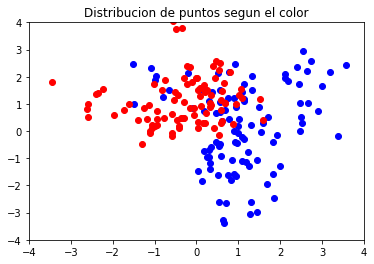

In [29]:
visualize_colors(ptos_observados_azul_train, ptos_observados_rojo_train)

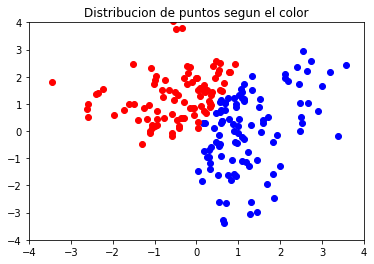

In [30]:
visualize_colors(lista_de_predicciones_azul_train_t, lista_de_predicciones_rojo_train_t)

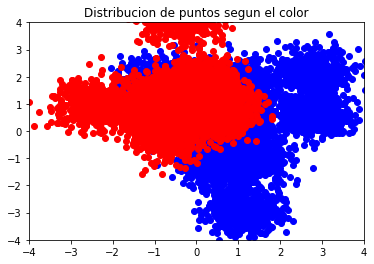

In [31]:
visualize_colors(ptos_observados_azul_test, ptos_observados_rojo_test)

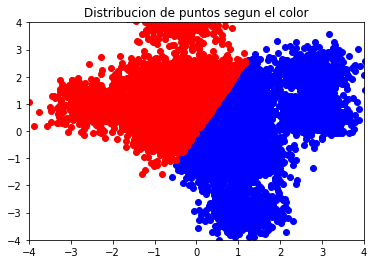

In [32]:
visualize_colors(lista_de_predicciones_azul_test_t, lista_de_predicciones_rojo_test_t)

### Evaluación de la hipotesis lineal en terminos de las metricas accuracy y el test error

Por definicion vamos a considerar que la accuracy y el test error estan dados por

accuracy = ptos_predichos_correctamente/(ptos_predichos_correctamente + ptos_predichos_incorrectamente)

test_error = 1 - accuracy

Estan son unas metricas que nos permiten evaluar la performance de la hipotesis una vez que hemos encontrado los valores de los parametros libres (theta). Por lo que se puede ver es posible evaluar estas métricas en ambos sets, el del train y el del test. 

El valor de la accuracy medido en el train nos indica cuantitativamente el nivel del aprendizaje del modelo, dado que en este paso estamos intentando ajustar el modelo a los datos conocidos, mientras que medido en el test nos indica su poder de prediccion, dado que estos datos no fueron utilizados para el entrenamiento del modelo. 

Normalmente se espera que el valor de la accuracy sea mejor en el set de entrenamiento que en el set del test, porque los primeros fueron los datos usados para calcular los parametros del modelo. Sin embargo esto no esta garantizado matematicamente.

En general es bastante recomendado obtener un valor alto de accuracy en el test dado que nuestro objectivo final es tener poder de prediccion, no solo ajustar los datos conocidos

In [33]:
def accuracy_funcion_lineal(SET, beta):

    pto_correcto = 0
    pto_incorrecto = 0
    
    for pto in range(len(SET)):
        prediccion = funcion_lineal(SET[pto][1], SET[pto][2], beta)
        
        if (((prediccion < 0.5) and (SET[pto][3]==0)) or
            ((prediccion > 0.5) and (SET[pto][3]==1))):
            
            pto_correcto = pto_correcto + 1
        else:
            pto_incorrecto = pto_incorrecto + 1
            
        ratio = pto_correcto/(pto_correcto + pto_incorrecto)
        
        
    print("ptos correctos: %d y ptos incorrectos: %d"%(pto_correcto, pto_incorrecto))
        
    return ratio

### Evaluación del modelo usando el train

In [34]:
train_accuracy = accuracy_funcion_lineal(SET_train, beta_teorico)
train_error = 1 - train_accuracy
print("train accuracy: %.2f and test error: %.2f "%(train_accuracy, train_error))

ptos correctos: 166 y ptos incorrectos: 34
train accuracy: 0.83 and test error: 0.17 


### Evaluación del modelo usando el test

In [35]:
test_accuracy = accuracy_funcion_lineal(SET_test, beta_teorico)
test_error = 1 - test_accuracy
print("test accuracy: %.2f and test error: %.2f "%(test_accuracy, test_error))

ptos correctos: 8218 y ptos incorrectos: 1782
test accuracy: 0.82 and test error: 0.18 


### Caso 2:

- Hipótesis 2: KNN
- Función costo: No existe 
- Minimización: No existe
- Evaluación: accuracy y test error

Debemos notar que KNN es un caso bastante particular en Machine Learning dado que no podemos seguir el mismo proceso mencionado anteriormente para la hipótesis lineal, el cual es util en muchos otros ejemplos (esto lo veremos mas claramente siguiendo el curso de Machine Learning). Esto básicamente sucede porque cualquier función costo que mida la cercania entre la prediccion del color en un punto del train con los valores conocidos del train entregara N = 1 (un vecino cercano, el mismo punto). 

Por otro lado es posible buscar el valor de N talque el poder predictivo de KNN sea optimizado. Por ejemplo, se puede buscar aquel valor de N tal que maximize la accuracy con respecto a los datos del test, pero solo usando los puntos del train para el calculo de la prediccion. Esto es lo que nos permite justamente el gráfico 2.4 del libro The Elements. Entonces algunas preguntas a responder son:

Cual es el valor de N que maximiza la accuracy (minimiza el test error) medida en los puntos del test?

Es aquel valor de la accuracy mayor o menor que en el caso lineal?

AC: Para comenzar, visualizaremos la predicción que entrega el KNN method, para lo cual necesitamos crear ciertas funciones

In [36]:
def MinimumDistance(punto,SET):
    distancia_min=1000
    for i in range(len(SET)):
        d=np.sqrt((SET[i][1]-punto[0])**2+(SET[i][2]-punto[1])**2)
        if d <= distancia_min:
            distancia_min=d
            punto_min=[SET[i][0],SET[i][1],SET[i][2],SET[i][3]]
    return distancia_min,punto_min  

def k_puntos_mas_cercanos(pto,SET,k):
    set_copia =SET.copy()    #aquí genero esta copia porque no quiero que esta función me modifique el SET original
    lista_vecinos=[]
   
    for i in range(k+1):                                  #esto buscará k+1 veces para solucionar el problema de que la funcion
        punto_cercano = MinimumDistance(pto,set_copia)[1] #MinimumDistance() tome al mismo punto de prueba como un punto cercano
        lista_vecinos.append(punto_cercano)
        set_copia.remove(punto_cercano)
    
    if [lista_vecinos[0][1],lista_vecinos[0][2]] == pto:  #esto es TRUE cuando pto está en SET
        lista_vecinos.remove(lista_vecinos[0])      # aquí borro pto, ya que se estaba contando a si mismo como pto más cercano
        
    else:                                           #Si entra al else, quiere decir que el pto no se encuentra en SET
        lista_vecinos.pop()                         #Entonces borramos el último punto agregado a la lista (por eso puse
    
    return lista_vecinos                            # el for en un rango de k+1 


def promedio(lista_puntos):
    suma_total=0
    
    for elemento in lista_puntos:
        suma_total = suma_total + elemento[3]
    
    prom = suma_total / len(lista_puntos)    
    
    return prom


def prediccion_knn(SET,k):
    LISTA_AZUL=[]
    LISTA_ROJO=[]
    
    for elemento in range(len(SET)):
    
        pto = [SET[elemento][1],SET[elemento][2]]
        lista_vecinos_cercanos=k_puntos_mas_cercanos(pto,SET,k)
        y_hat = promedio(lista_vecinos_cercanos)
    
        if y_hat > 0.5:
            LISTA_ROJO.append([SET[elemento][1],SET[elemento][2]])
        else :
            LISTA_AZUL.append([SET[elemento][1],SET[elemento][2]])
    
    return LISTA_AZUL , LISTA_ROJO

Probemos, por ejemplo, como resulta la predicción con 15 vecinos. Utilizaré el SET_training y el SET_test_2

In [37]:
puntosAzul_train, puntosRojo_train = prediccion_knn(SET_train,15)

In [38]:
puntosAzul_test_2, puntosRojo_test_2 = prediccion_knn(SET_test_2,15)

In [39]:
print(len(puntosAzul_train),len(puntosRojo_train),len(puntosAzul_test_2),len(puntosRojo_test_2))

85 115 458 542


In [40]:
puntosAzul_train_t = np.array(puntosAzul_train).transpose()
puntosRojo_train_t = np.array(puntosRojo_train).transpose() 
puntosAzul_test_t = np.array(puntosAzul_test_2).transpose()
puntosRojo_test_t = np.array(puntosRojo_test_2).transpose() 

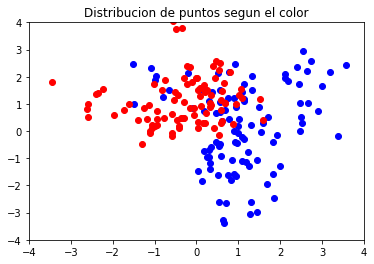

In [41]:
visualize_colors(ptos_observados_azul_train, ptos_observados_rojo_train)

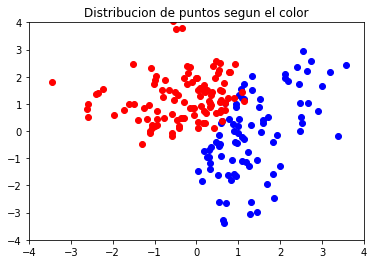

In [42]:
visualize_colors(puntosAzul_train_t,puntosRojo_train_t)

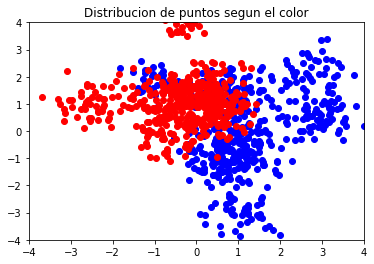

In [43]:
visualize_colors(ptos_observados_azul_test_2, ptos_observados_rojo_test_2)

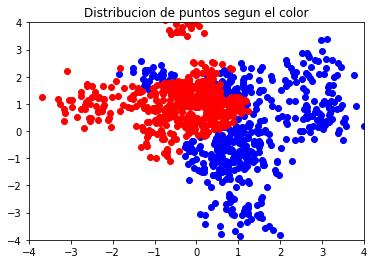

In [44]:
visualize_colors(puntosAzul_test_t,puntosRojo_test_t)

### Evaluación de la hipotesis lineal en terminos de las metricas accuracy y el test error

In [45]:
def accuracy_knn(SET,k):
    pto_correcto = 0
    pto_incorrecto = 0
    
    for pto in range(len(SET)):
    
        punto_de_prueba = [SET[pto][1],SET[pto][2]]
        lista_vecinos_cercanos = k_puntos_mas_cercanos(punto_de_prueba,SET,k)
        prediccion = promedio(lista_vecinos_cercanos)
        
        if (((prediccion < 0.5) and (SET[pto][3]==0)) or ((prediccion > 0.5) and (SET[pto][3]==1))):

             pto_correcto = pto_correcto + 1
                
        else:
            pto_incorrecto = pto_incorrecto + 1
            
        ratio = pto_correcto/(pto_correcto + pto_incorrecto)
        
    return ratio

### Evaluación del modelo usando el train para un k fijo

Primero probemos la función accuracy_knn() para un numero fijo de vecinos (k=3)

In [46]:
train_accuracy_knn = accuracy_knn(SET_train,3)
train_error_knn = 1 - train_accuracy_knn
print("train accuracy of k=3: %.2f and test error of k=3: %.2f "%(train_accuracy_knn, train_error_knn))

train accuracy of k=3: 0.79 and test error of k=3: 0.21 


### Evaluación del modelo usando el test_2 para un k fijo

In [47]:
test_accuracy_knn = accuracy_knn(SET_test_2,3)
test_error_knn = 1 - test_accuracy_knn
print("test accuracy of k=3: %.2f and test error of k=3: %.2f "%(test_accuracy_knn, test_error_knn))

test accuracy of k=3: 0.83 and test error of k=3: 0.17 


### Evaluación del modelo usando varios k

In [48]:
lista_vecinos_train = [1]                                     #agregué la predicción con un solo vecino, ya que esta no será 
lista_train_error_knn = [1-accuracy_knn(SET_train,1)]         #contemplada en el for

for i in range(3,52,3):
    test_error = 1 - accuracy_knn(SET_train,i)
    print(i)  #esto lo puse para ver el avance del programa cuando lo ejecuto
    lista_vecinos_train.append(i)
    lista_train_error_knn.append(test_error)

3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51


In [50]:
numero_vecino_test = [1]
lista_train_error_knn_test = [1-accuracy_knn(SET_test_2,1)]

for i in range(3,52,3):  #hacemos saltos de a 3 para asimilar lo que sale en el libro
    test_error = 1 - accuracy_knn(SET_test_2,i)
    print(i)  #esto lo puse para ver el avance del programa cuando lo hago correr
    numero_vecino_test.append(i)
    lista_train_error_knn_test.append(test_error)

3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51


In [51]:
lista_vecinos_train = np.array(lista_vecinos_train)
lista_train_error_knn = np.array(lista_train_error_knn)

numero_vecino_test = np.array(numero_vecino_test)
lista_train_error_knn_test = np.array(lista_train_error_knn_test)

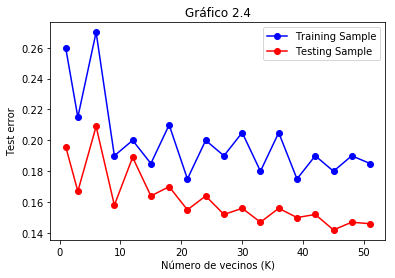

In [52]:
plt.plot(lista_vecinos_train,lista_train_error_knn,"bo-", label = "Training Sample")
plt.plot(numero_vecino_test,lista_train_error_knn_test,"ro-", label = "Testing Sample")
plt.title("Gráfico 2.4")
plt.xlabel("Número de vecinos (K)")
plt.ylabel("Test error")
plt.legend()
plt.show()